<a href="https://colab.research.google.com/github/truongthuanr/self-learning-project/blob/main/02_SpamMailDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infomation

Data Resource: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

Reference materials: 


# Import data 

In [1]:
url = "https://raw.githubusercontent.com/truongthuanr/self-learning-project/main/dataset/smsspamemail/SMSSpamCollection"

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(url,sep="\t",names=["label","messages"])

In [4]:
df.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df.groupby('label').describe()

messages                                                               
         count unique                                                top freq
label                                                                        
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

Adding length of each message to dataframe

In [7]:
df['length'] = df['messages'].apply(len)
df.head()

,label,messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


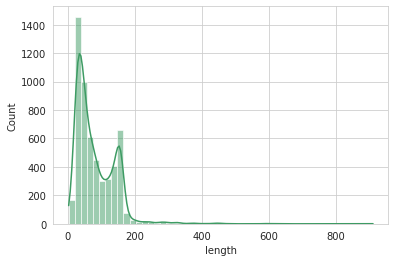

In [8]:
sns.set_style('whitegrid')
sns.histplot(df.length, bins=50, kde=True, color="#3D9B63")

In [9]:
df.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

discover the distribution by label

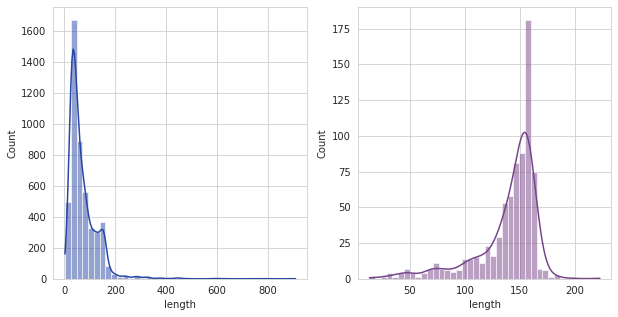

In [10]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
sns.histplot(ax=axes[0], data=df[df['label']=="ham"].length, bins=40, kde=True, color="#2847A4")
sns.histplot(ax=axes[1], data=df[df['label']=="spam"].length, bins=40, kde=True, color="#76448A")

# Text Pre-processing 

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import string
from nltk.corpus import stopwords

In [31]:
# Create a function to process the text
def text_process(mess):
  """
  Takes in a string of text, then performs the following:
  1. Remove all punctuation
  2. Remove all stop words
  3. Return a list of the cleaned text
  """
  # remove the punctuation in the string
  nopunc = [char for char in mess if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  # remove all stop words
  ret = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
  
  return ret

In [34]:
# Quick check
df.messages.head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: messages, dtype: object

## Tokenize

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
transformer = CountVectorizer(analyzer=text_process).fit(df['messages'])


Length of vocab:  11425


In [42]:
transformed_messages = transformer.transform(df["messages"])

In [57]:
print("Number of messages in  data: ", len(df.messages))
print("Length of vocab: ",len(transformer.vocabulary_))
print("Shape of Sparse matrix: ", transformed_messages.get_shape())

Number of messages in  data:  5572
Length of vocab:  11425
Shape of Sparse matrix:  (5572, 11425)


In [55]:
transformed_messages.get_shape()

(5572, 11425)

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer

In [59]:
tfidf_transformer = TfidfTransformer().fit(transformed_messages)

Transform the entire bag-of-word corpus into TF-IDF corpus:

In [60]:
tfidf_messages = tfidf_transformer.transform(transformed_messages)

In [63]:
print("shape of tfidf messages: ", tfidf_messages.shape)

shape of tfidf messages:  (5572, 11425)


# Model

## Data for training and testing

In [66]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df['messages'], df["label"], test_size=0.25, random_state=42)

## Data Pipeline

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [71]:
pipeline = Pipeline([
                     ('bagofword', CountVectorizer(analyzer=text_process)), #tokenize
                     ('tfidf', TfidfTransformer()), 
                     ('classifier', MultinomialNB()),
])

## Train model

In [72]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bagofword',
                 CountVectorizer(analyzer=<function text_process at 0x7fb428924680>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

## Evaluate

In [73]:
from sklearn.metrics import classification_report

In [75]:
predictions = pipeline.predict(X_test)

In [76]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1252
        spam       0.76      1.00      0.86       141

    accuracy                           0.97      1393
   macro avg       0.88      0.98      0.92      1393
weighted avg       0.98      0.97      0.97      1393

